## Sagnac Frequency - Compare Drift of Rings

## Imports

In [26]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
# from scipy.signal import hilbert
# from datetime import datetime, date


In [54]:
from functions.read_sds import __read_sds
from functions.smoothing import __smooth
from functions.reduce import __reduce
from functions.interpolate_nan import __interpolate_nan

In [27]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [61]:
config = {}

# config['name'] = "insulation"
# config['tbeg'] = UTCDateTime("2024-03-09 00:00")
# config['tend'] = UTCDateTime("2024-04-09 00:00")
# Zlower, Zupper = 553.542, 553.564
# Ulower, Uupper = 302.40, 302.50
# Vlower, Vupper = 447.725, 447.74

# config['name'] = "longterm"
# config['tbeg'] = UTCDateTime("2024-01-23 00:00")
# config['tend'] = UTCDateTime("2024-06-30 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.4, 302.48
# Vlower, Vupper = 447.72, 447.78

config['name'] = "shortterm"
config['tbeg'] = UTCDateTime("2024-07-06 00:00")
config['tend'] = UTCDateTime("2024-07-17 00:00")
Zlower, Zupper = 553.52, 553.58
Ulower, Uupper = 302.4, 302.48
Vlower, Vupper = 447.72, 447.78

# time sampling
config['delta'] = 60

# window length for moving average
config['n_minutes'] = 24 * config['delta']

# specify path to figures
config['path_to_figs'] = "./figures/"
config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"

# specify path to data
config['path_to_data'] = "./data/"
config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"


In [30]:
beatZ = read_pickle(config['path_to_data']+f"beatz_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")
beatU = read_pickle(config['path_to_data']+f"beatu_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")
beatV = read_pickle(config['path_to_data']+f"beatv_drift_{config['tbeg'].date}_{config['tend'].date}.pkl")


In [31]:
def __makeplot0(beat1, beat2, beat3, key, limits=True):

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beat1.times_utc_sec*time_scaling, beat1[key])
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beat2.times_utc_sec*time_scaling, beat2[key])
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beat3.times_utc_sec*time_scaling, beat3[key])
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    if limits:
        ax[0].set_ylim(Zlower, Zupper)
        ax[1].set_ylim(Ulower, Uupper)
        ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


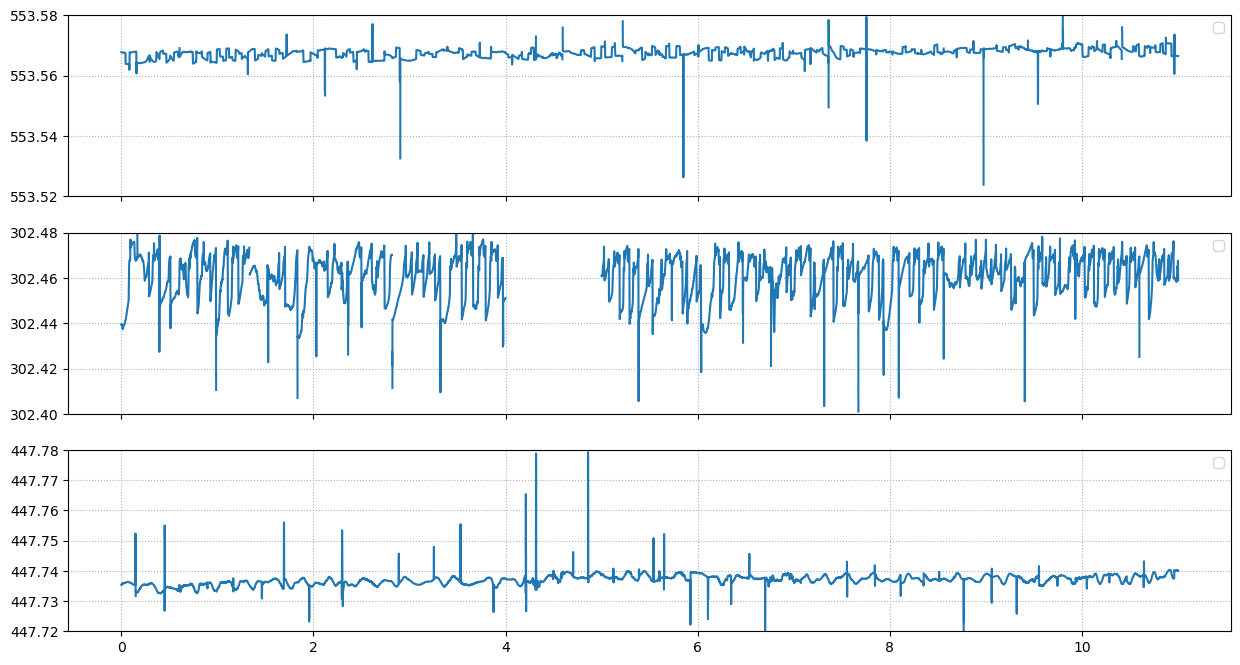

In [32]:
fig = __makeplot0(beatZ, beatU, beatV, "fj");

### Load Maintenance LXX log

In [33]:
# load lxx log
lxx = read_pickle(config['path_to_data']+f"lxx__{config['tbeg'].date}_{config['tend'].date}.pkl")

# extract time intervals
lxx_t1, lxx_t2 = lxx.t1, lxx.t2


### Load MLTI Statistics

In [34]:
mltistats = read_pickle(config['path_to_data']+f"mltistats_{config['tbeg'].date}_{config['tend'].date}.pkl")

In [35]:
def __makeplot_mlti_statistics(data, ylog=False, sec=False):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    tscale = 1/86400

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    plt.subplots_adjust(wspace=0.15)

    colors = {"Z":"tab:blue", "U":"tab:green", "V":"tab:red"}

    s_max = []
    for r in data.keys():
        s_max.append(max(data[r]["cumsumsec"]))
    s_max = max(s_max)

    if s_max > 3600:
        sscale, sunit = 1/60, "min"
    elif s_max > 86400:
        sscale, sunit = 1/3600, "hour"
    else:
        sscale, sunit = 1, "s"

    offset = [-0.3, 0, 0.3]
    for _i, r in enumerate(data.keys()):

        n = data[r]["cumsum"][-1].astype(int)

        if sec:
            ax[0].plot(data[r]["tsec"]*tscale, data[r]["cumsumsec"]*sscale, label=f"R{r} (N={n})", color=colors[r], zorder=3)
            ax[0].set_ylim(0, s_max*sscale)
            ax[0].set_ylabel(f"MLTI time ({sunit})", fontsize=12)
        else:
            ax[0].plot(data[r]["tsec"]*tscale, data[r]["cumsump"], label=f"R{r} (N={n})", color=colors[r], zorder=3)
            ax[0].set_ylim(0, 102)
            ax[0].set_ylabel("MLTI Count (%)", fontsize=12)

        imax = round(max(data[r]["intersec"]/3600), 1)
        h, b = np.histogram(data[r]["intersec"]/3600, bins=int(24/1), range=(0, 24))
        bins = b[:-1] + b[1]/2 + offset[_i]
        ax[1].bar(bins, h, width=0.3, color=colors[r], label=f"R{r} (max={imax} hours)")

    if ylog:
        ax[1].set_yscale("log")

    ax[0].set_xlim(0-0.5, max(data[r]["tsec"]*tscale)+0.5)
    ax[1].set_xlim(0-0.2, 24+0.2)

    ax[0].legend(loc=9)
    ax[1].legend(loc=9)

    ax[0].grid(color="grey", ls="--", alpha=0.4)
    ax[1].grid(color="grey", ls="--", alpha=0.4)

    ax[0].set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=12)

    ax[1].set_xlabel("Inter-MLTI-Time (hours)", fontsize=12)
    ax[1].set_ylabel("MLTI Count", fontsize=12)

    ax[0].xaxis.set_major_locator(MultipleLocator(2))
    ax[0].xaxis.set_minor_locator(MultipleLocator(1))
    ax[1].xaxis.set_major_locator(MultipleLocator(4))
    ax[1].xaxis.set_minor_locator(MultipleLocator(1))

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.006, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=14)

    # add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = (lx1-UTCDateTime(config['tbeg']))*tscale
        lx2_sec = (lx2-UTCDateTime(config['tbeg']))*tscale
        ax[0].fill_betweenx([-10000, 10000], lx1_sec, lx2_sec, color="yellow", alpha=0.7)


    plt.show();
    return fig

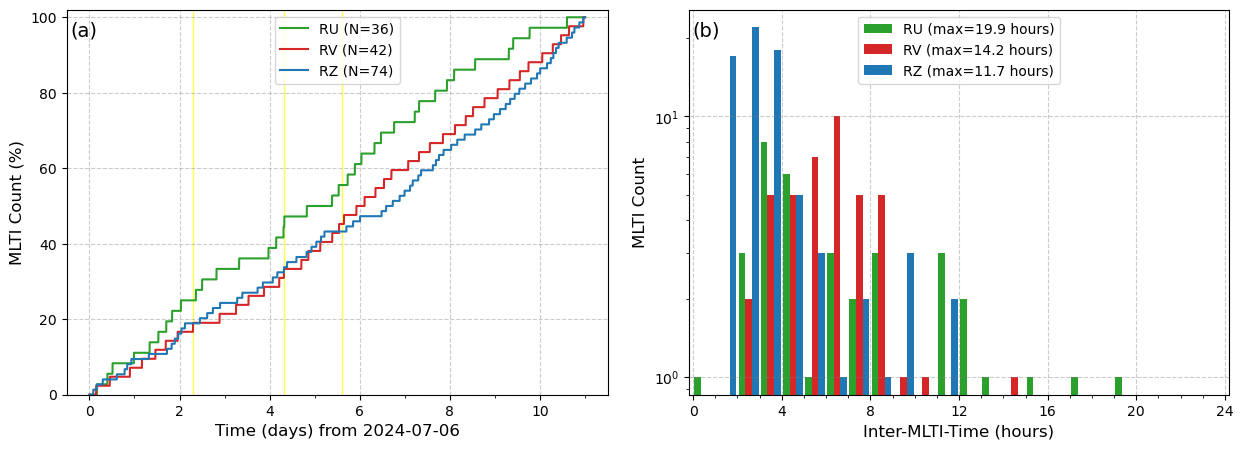

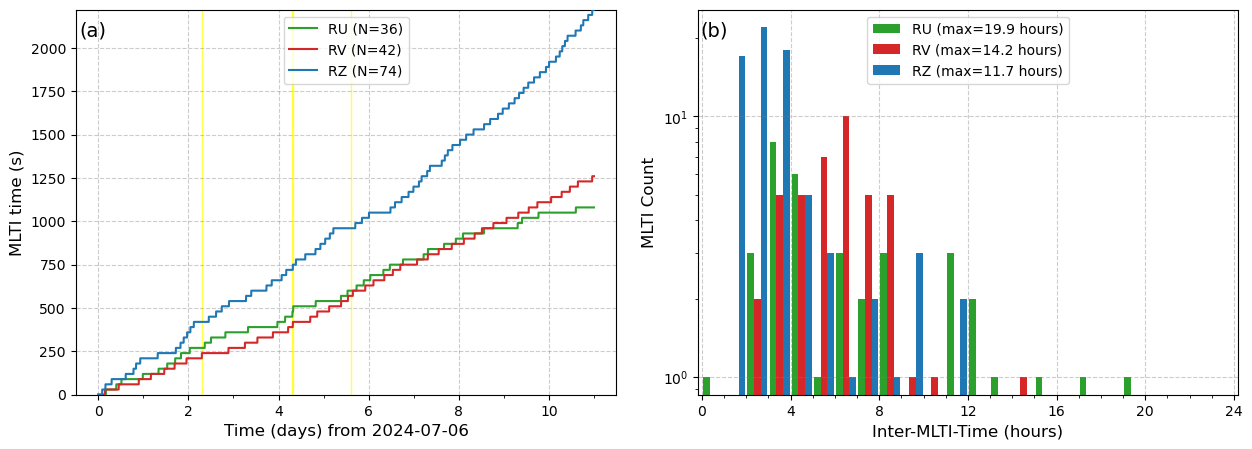

In [36]:
fig = __makeplot_mlti_statistics(mltistats, ylog=True, sec=False)

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_mlti_statistics.png",
            format="png", dpi=150, bbox_inches='tight')

fig = __makeplot_mlti_statistics(mltistats, ylog=True, sec=True)

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_mlti_statistics_secs.png",
            format="png", dpi=150, bbox_inches='tight')

## Plotting

/tmp/ipykernel_469897/1538401363.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


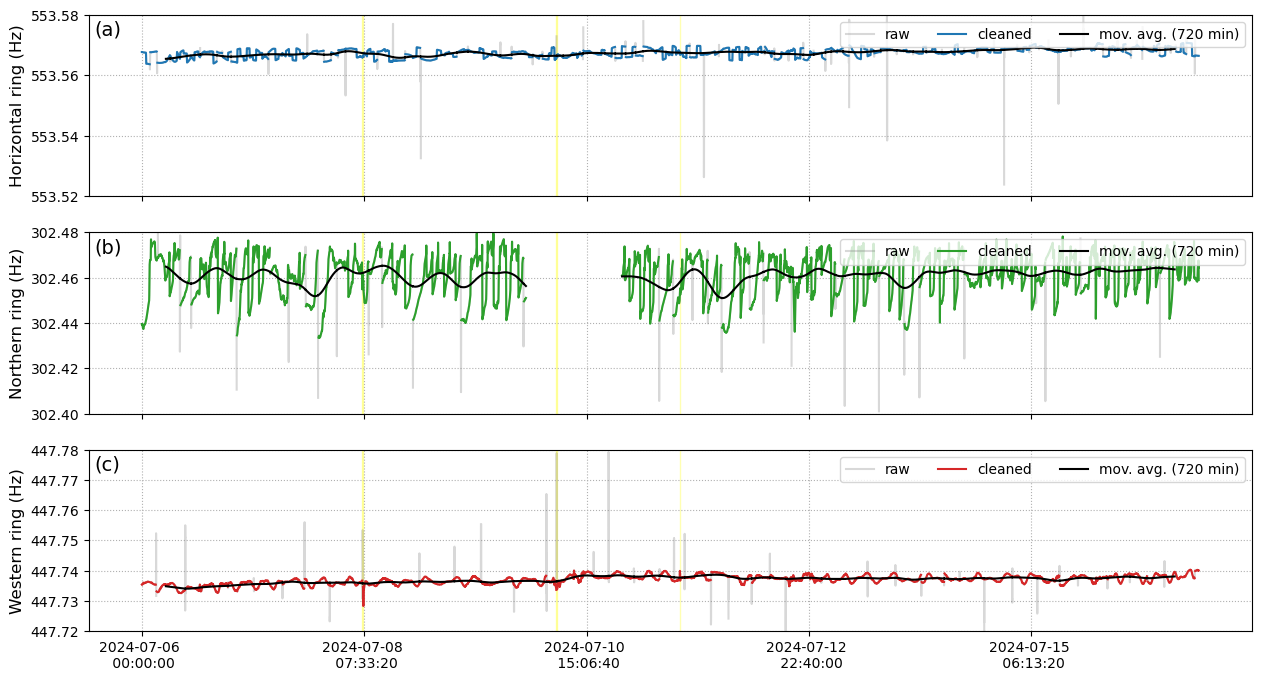

In [37]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_smoothed.png",
            format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_469897/926773714.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


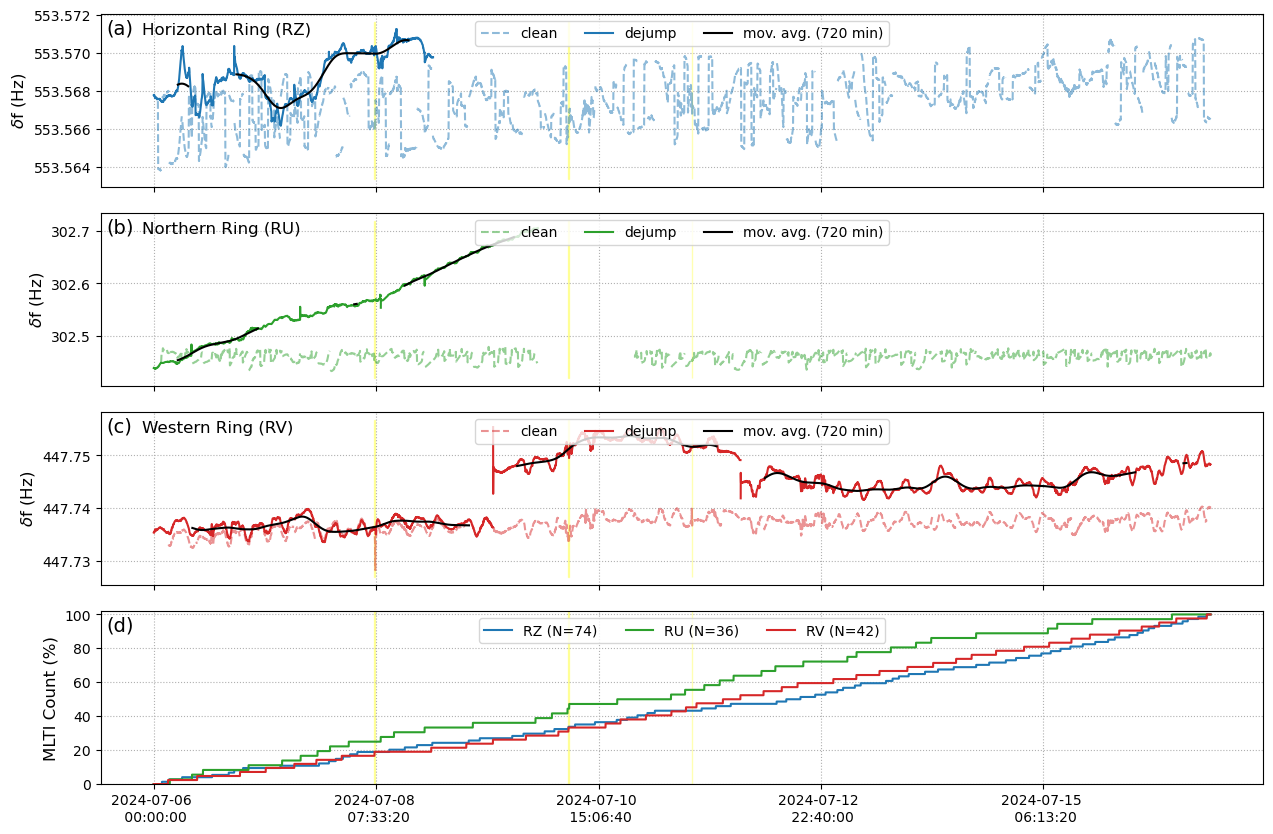

In [38]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # time_scaling = 1/86400
    time_scaling = 1

    # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="clean", ls="--", alpha=0.5)
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj, color="tab:blue", label="dejump")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[0].text(.035, .95, "Horizontal Ring (RZ)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)

    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="clean", ls="--", alpha=0.5)
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj, color="tab:green", label="dejump")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[1].text(.035, .95, "Northern Ring (RU)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)

    # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="clean", ls="--", alpha=0.5)
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj, color="tab:red", label="dejump")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[2].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[2].text(.035, .95, "Western Ring (RV)", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("$\delta$f (Hz)", fontsize=font)

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    ax[3].plot(mltistats['Z']['tsec']*time_scaling, mltistats['Z']['cumsump'], color="tab:blue", label=f"RZ (N={n_rz})")
    ax[3].plot(mltistats['U']['tsec']*time_scaling, mltistats['U']['cumsump'], color="tab:green", label=f"RU (N={n_ru})")
    ax[3].plot(mltistats['V']['tsec']*time_scaling, mltistats['V']['cumsump'], color="tab:red", label=f"RV (N={n_rv})")
    # ax[3].set_yscale("log")
    # ax[3].set_ylim(0, max([n_rz, n_rv, n_ru])+2)
    ax[3].set_ylim(0, 102)
    ax[3].set_ylabel("MLTI Count (%)", fontsize=font)

    # ax[0].set_ylim(Zlower, Zupper)
    # ax[1].set_ylim(Ulower, Uupper)
    # ax[2].set_ylim(Vlower, Vupper)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=9, ncol=4)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_dejump_smoothed.png",
#             format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_469897/507694921.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


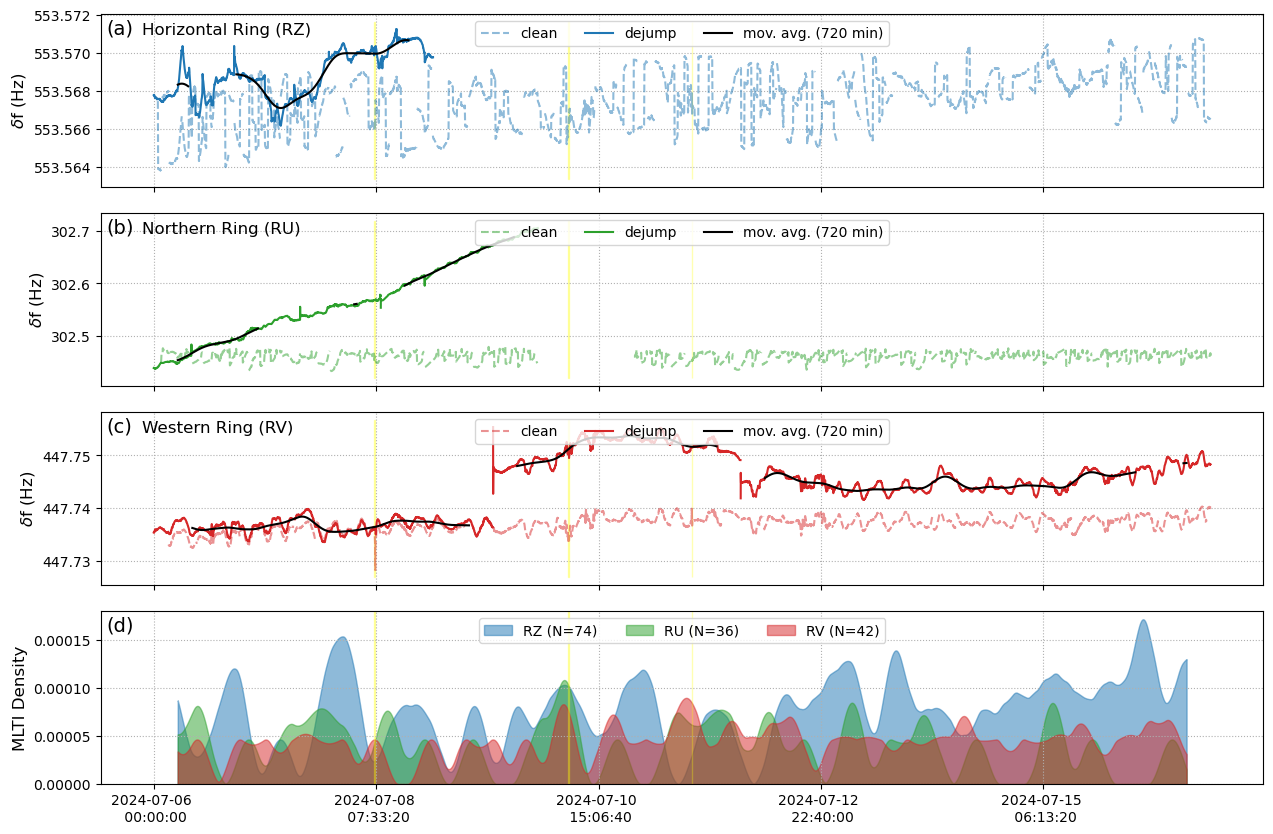

In [39]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # time_scaling = 1/86400
    time_scaling = 1

    # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="clean", ls="--", alpha=0.5)
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj, color="tab:blue", label="dejump")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[0].text(.035, .95, "Horizontal Ring (RZ)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)

    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="clean", ls="--", alpha=0.5)
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj, color="tab:green", label="dejump")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[1].text(.035, .95, "Northern Ring (RU)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)

    # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="clean", ls="--", alpha=0.5)
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj, color="tab:red", label="dejump")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj_smooth, color="k", label=f"mov. avg. ({config['n_minutes']} min)")
    ax[2].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[2].text(.035, .95, "Western Ring (RV)", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("$\delta$f (Hz)", fontsize=font)

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    # ax[3].plot(mltistats['Z']['tsec']*time_scaling, mltistats['Z']['mlti_series_avg'], color="tab:blue", label=f"RZ (N={n_rz})")
    # ax[3].plot(mltistats['U']['tsec']*time_scaling, mltistats['U']['mlti_series_avg'], color="tab:green", label=f"RU (N={n_ru})")
    # ax[3].plot(mltistats['V']['tsec']*time_scaling, mltistats['V']['mlti_series_avg'], color="tab:red", label=f"RV (N={n_rv})")
    ax[3].fill_between(mltistats['Z']['tsec']*time_scaling, 0, mltistats['Z']['mlti_series_avg'],
                       color="tab:blue", label=f"RZ (N={n_rz})", alpha=0.5,
                      )
    ax[3].fill_between(mltistats['U']['tsec']*time_scaling, 0, mltistats['U']['mlti_series_avg'],
                       color="tab:green", label=f"RU (N={n_ru})", alpha=0.5,
                      )
    ax[3].fill_between(mltistats['V']['tsec']*time_scaling, 0, mltistats['V']['mlti_series_avg'],
                       color="tab:red", label=f"RV (N={n_rv})", alpha=0.5,
                      )

    ax[3].set_ylim(bottom=0)
    ax[3].set_ylabel(f"MLTI Density", fontsize=font)

    # ax[0].set_ylim(Zlower, Zupper)
    # ax[1].set_ylim(Ulower, Uupper)
    # ax[2].set_ylim(Vlower, Vupper)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=9, ncol=4)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_dejump_smoothed.png",
            format="png", dpi=150, bbox_inches='tight')


### load water level data

In [42]:
from functions.load_water_level import __load_water_level

try:
    # load data
    pegel = __load_water_level(config['tbeg'], config['tend'], path_to_data=lamont_path+"Pegel/")

    # remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

except:
    print(" -> pegel not loaded")


### load tiltmeter data

  -> converted data of ROMYT
3 Trace(s) in Stream:
BW.ROMYT..MAE | 2024-07-05T23:49:59.934999Z - 2024-07-17T00:09:59.934999Z | 20.0 s, 47581 samples
BW.ROMYT..MAN | 2024-07-05T23:49:59.935000Z - 2024-07-17T00:09:59.935000Z | 20.0 s, 47581 samples
BW.ROMYT..MAT | 2024-07-05T23:49:59.935000Z - 2024-07-17T00:09:59.935000Z | 20.0 s, 47581 samples


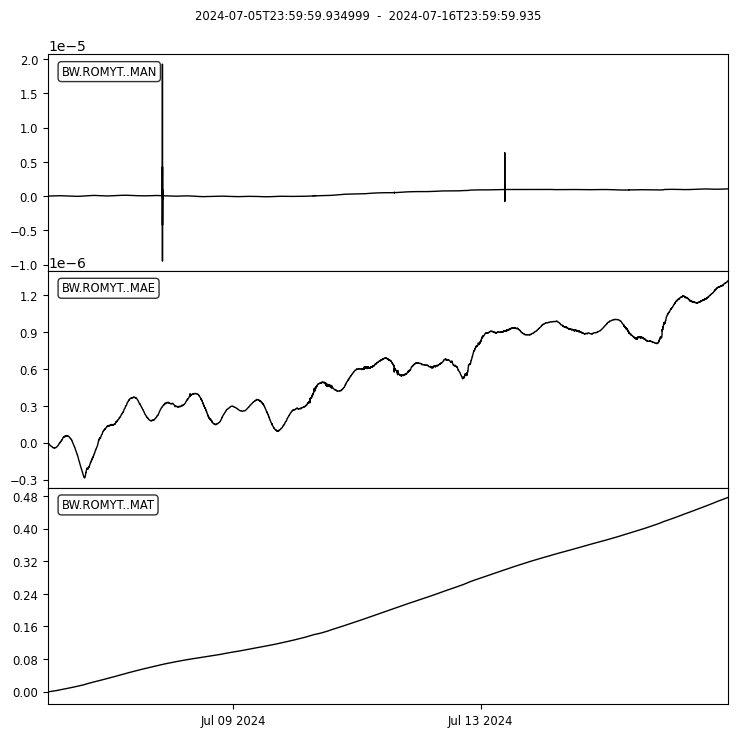

In [55]:
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.read_yaml import __readYaml

path_to_tilt = archive_path+"romy_archive/"

tromy = Stream()
tromy += __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy = __conversion_to_tilt(tromy, confTilt['TROMY'])

tromy = tromy.merge(fill_value="interpolate");

tromy = tromy.decimate(10, no_filter=False)
tromy = tromy.decimate(10, no_filter=False)

print(tromy)

tromy = tromy.trim(config['tbeg'], config['tend'])

for tr in tromy:
    tr.data = __reduce(tr.data, 10)

tromy.plot(equal_scale=False);


In [56]:
Nsmooth = int(config['n_minutes']*60*tromy.select(channel="*N")[0].stats.sampling_rate)

tromyN_smooth = __smooth(tromy.select(channel="*N")[0].data, Nsmooth)
tromyE_smooth = __smooth(tromy.select(channel="*E")[0].data, Nsmooth)

In [57]:
v0 = tromyN_smooth[~np.isnan(tromyN_smooth)][0]

if v0 > 0:
    tromyN_smooth += v0
else:
    tromyN_smooth -= v0


### Plotting

/tmp/ipykernel_469897/3588179241.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


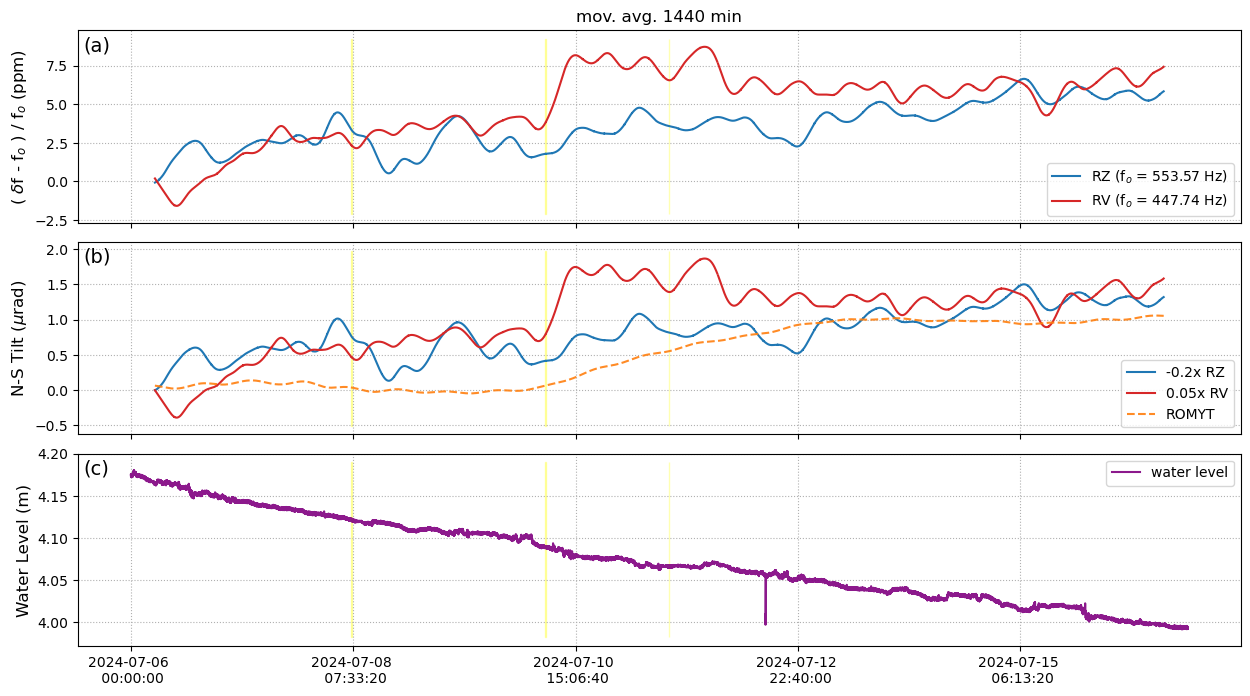

In [63]:
def __makeplot_tilt_pegel(_key1, _key2):

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1

    tilt_scaling = 1e6

    fscale = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # f0_U = round(beatU.fj.iloc[0], 2)
    f0_V = round(beatV.fj.iloc[0], 2)
    f0_Z = round(beatZ.fj.iloc[0], 2)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ[_key1]/f0_Z*fscale,
               color="tab:blue", label=f"RZ (f$_o$ = {f0_Z} Hz)")
    # ax[0].plot(beatU.times_utc_sec*time_scaling, beatU[_key1]/f0_U*fscale,
    #            color="tab:green", label=f"RU (f$_o$ = {f0_U} Hz)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV[_key1]/f0_V*fscale,
               color="tab:red", label=f"RV (f$_o$ = {f0_V} Hz)")

    ax[0].ticklabel_format(useOffset=False)
    # ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)
    ax[0].set_ylabel("( $\delta$f - f$_o$ ) / f$_o$ (ppm)", fontsize=font)

    z0 = beatZ[_key2].dropna().iloc[0]
    # u0 = beatU[_key2].dropna().iloc[0]
    v0 = beatV[_key2].dropna().iloc[0]

    fz, fv, fu = -0.2, 0.05, 0.1
    ax[1].plot(beatZ.times_utc_sec*time_scaling, fz*(beatZ[_key2]-z0)*tilt_scaling,
               color="tab:blue", label=f"{fz}x RZ")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, fu*(beatU[_key2]-u0)*tilt_scaling,
    #            color="tab:green", label=f"{fu}x RU")
    ax[1].plot(beatV.times_utc_sec*time_scaling, fv*(beatV[_key2]-v0)*tilt_scaling,
               color="tab:red", label=f"{fv}x RV")
    # ax[1].set_ylim(-2, 7)

    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_date),
               tromyN_smooth*tilt_scaling,
               label="ROMYT",
               color="tab:orange", alpha=0.9, zorder=3, ls="--")

    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)

    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    ax[2].legend(loc=1)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # add labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ax[0].set_title(f"mov. avg. {config['n_minutes']} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel("fj_reduced_masked", "tilt_ns_reduced_masked");

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_tilt_pegel.png",
            format="png", dpi=150, bbox_inches='tight')


### load barometer data

In [64]:
ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

ffbi.merge(fill_value="interpolate")


1 Trace(s) in Stream:
BW.FFBI.30.LDO | 2024-07-06T00:00:00.005000Z - 2024-07-16T23:59:59.005000Z | 1.0 Hz, 950400 samples

/tmp/ipykernel_469897/2400808645.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


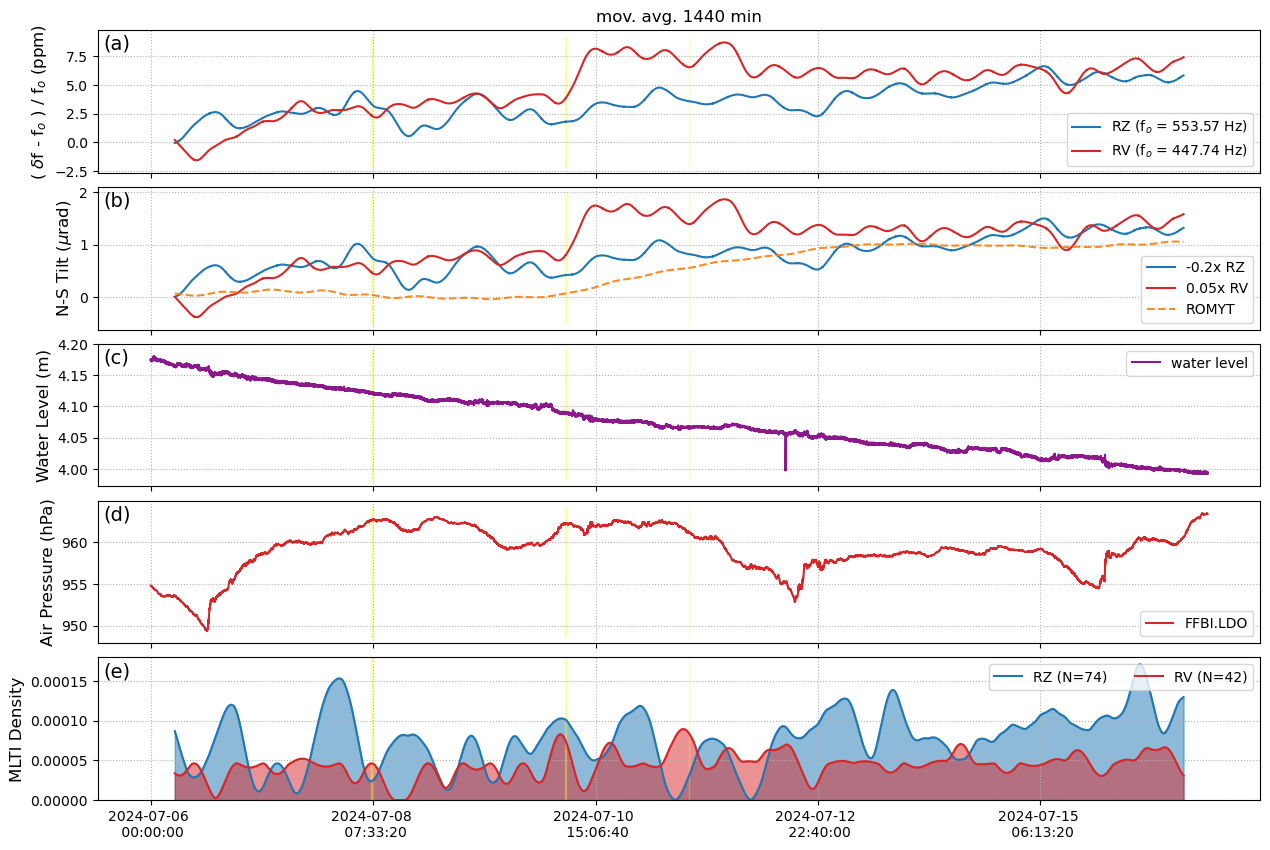

In [66]:
def __makeplot_tilt_pegel_baro(_key1, _key2):

    Nrow, Ncol = 5, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1

    tilt_scaling = 1e6

    fscale = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    f0_U = round(beatU.fj.iloc[0], 2)
    f0_V = round(beatV.fj.iloc[0], 2)
    f0_Z = round(beatZ.fj.iloc[0], 2)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ[_key1]/f0_Z*fscale,
               color="tab:blue", label=f"RZ (f$_o$ = {f0_Z} Hz)")
    # ax[0].plot(beatU.times_utc_sec*time_scaling, beatU[_key1]/f0_U*fscale,
    #            color="tab:green", label=f"RU (f$_o$ = {f0_U} Hz)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV[_key1]/f0_V*fscale,
               color="tab:red", label=f"RV (f$_o$ = {f0_V} Hz)")

    ax[0].ticklabel_format(useOffset=False)
    # ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)
    ax[0].set_ylabel("( $\delta$f - f$_o$ ) / f$_o$ (ppm)", fontsize=font)

    z0 = beatZ[_key2].dropna().iloc[0]
    u0 = beatU[_key2].dropna().iloc[0]
    v0 = beatV[_key2].dropna().iloc[0]

    fz, fv, fu = -0.2, 0.05, 0.1
    ax[1].plot(beatZ.times_utc_sec*time_scaling, fz*(beatZ[_key2]-z0)*tilt_scaling,
               color="tab:blue", label=f"{fz}x RZ")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, fu*(beatU[_key2]-u0)*tilt_scaling,
    #            color="tab:green", label=f"{fu}x RU")
    ax[1].plot(beatV.times_utc_sec*time_scaling, fv*(beatV[_key2]-v0)*tilt_scaling,
               color="tab:red", label=f"{fv}x RV")
    # ax[1].set_ylim(-2, 7)

    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_date),
               tromyN_smooth*tilt_scaling,
               label="ROMYT",
               color="tab:orange", alpha=0.9, zorder=3, ls="--")

    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)

    ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi.select(channel="*O")[0].data,
               label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
               color="tab:red")

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    ax[4].plot(mltistats['Z']['tsec']*time_scaling,
               mltistats['Z']['mlti_series_avg'],
               color="tab:blue", label=f"RZ (N={n_rz})"
              )
    # ax[4].plot(mltistats['U']['tsec']*time_scaling,
    #            mltistats['U']['mlti_series_avg'],
    #            color="tab:green", label=f"RU (N={n_ru})"
    #           )
    ax[4].plot(mltistats['V']['tsec']*time_scaling,
               mltistats['V']['mlti_series_avg'],
               color="tab:red", label=f"RV (N={n_rv})"
              )

    ax[4].fill_between(mltistats['Z']['tsec']*time_scaling, 0, mltistats['Z']['mlti_series_avg'],
                       color="tab:blue", alpha=0.5,
                      )
    # ax[4].fill_between(mltistats['U']['tsec']*time_scaling, 0, mltistats['U']['mlti_series_avg'],
    #                    color="tab:green", alpha=0.5,
    #                   )
    ax[4].fill_between(mltistats['V']['tsec']*time_scaling, 0, mltistats['V']['mlti_series_avg'],
                       color="tab:red", alpha=0.5,
                      )
    ax[4].set_ylim(bottom=0)
    ax[4].legend(loc=1, ncol=3)

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)
    # ax[4].set_ylabel("Cum. MLTI (%)", fontsize=font)
    ax[4].set_ylabel(f"MLTI Density", fontsize=font)

    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    ax[2].legend(loc=1)
    ax[3].legend(loc=4)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # add labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {config['n_minutes']} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel_baro("fj_reduced_masked", "tilt_ns_reduced_masked");

fig.savefig(config['path_to_figs']+f"BeatDrift_{config['name']}_tilt_pegel_baro_mlti.png",
            format="png", dpi=150, bbox_inches='tight')
